# Empirical2a - Use Miller data set to demonstrate that during task states, correlated variability is quenched; compute average FR for each region separately
## Using h5f data for faster i/o



## Takuya Ito
#### 08/01/2018

In [7]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
import bct
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
import seaborn as sns
plt.style.use("ggplot")
sns.set_style('whitegrid')
plt.rcParams["font.family"] = "FreeSans"
import nibabel as nib
import pandas as pd
import sys
import h5py
import statsmodels.api as sm
sys.path.append('../')
import dimensionality


In [335]:
# sessions = ['100804']
sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
            '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828',
            '100915','101008','101027','101123','101202','101209','110106','110110_02','110120','100725',
            '100802','100818','100824','100907','100917','101009','101028','101124','101203','101210',
            '110107_01','110111_01','110121','100726','100803','100819','100826','100910','100920','101023',
            '101030','101127','101206','101216','110107_02','110111_02']
# sessions = ['100706','100730','100804','100820','100827','100913','100921','101024','101122','101128',
#             '101207','101217','110110_01','110115_01','100724','100731','100817','100823','100828']

datadir = '/projects3/TaskFCMech/data/nhpData/'
tmin = -4000 # in ms
tmax = 4000 # in ms, this was my own doing


## Create spike-triggered average response, across all rules/stims

#### Use sliding window, 50ms sliding-window moving in 10ms (Churchland et al., 2010, Nat Neurosci)

In [49]:
def slidingWindow(data,binSize=50,shiftSize=10,nproc=10):
    """
    data - organized by time (ms) x trial, data represents data from only one region/neuron
    binsize - window size to compute number of spikes
    shiftsize - shift window by this amount
    
    Effectively downsamples data
    """
    
    tLength = data.shape[0]
    nTrials = data.shape[1]
    
    ###
    
    inputs = []
    for trial in range(nTrials):
        inputs.append((data[:,trial],binSize,shiftSize))
        
    pool = mp.Pool(processes=nproc)
    results = pool.map_async(_slide,inputs).get()
    pool.close()
    pool.join()
    
    out = []
    for result in results:
        out.append(result.T)
        
    outarray = np.zeros((result.shape[0],nTrials))
    for i in range(nTrials):
        outarray[:,i] = out[i]

    return outarray

### Helper function for parallel processing
def _slide((trialdata,binSize,shiftSize)):
    tLength = trialdata.shape[0]
    
    downSampledData = []
    i = 0
    while i < (tLength-binSize):
        downSampledData.append(np.mean(trialdata[i:(i+binSize)],axis=0))
        i += shiftSize

    return np.asarray(downSampledData)
        

# 1.0 Load all sessions

#### Load other meta-data associated with neurons + task info

## Compute downsampled firing rate using 50ms bins and 10ms shift

In [337]:
data = {}
data['area'] = []
data['session'] = []
data['spikes'] = []
data['spikesBinned'] = []
data['STA_byTask'] = []
data['taskInfo'] = []

sessioncount = 1
for session in sessions:
    print 'Loading data for session', session, '|', sessioncount, '/', len(sessions)
    
    taskInfo = pd.read_csv(datadir + session + '_trialInfoAllTasks.csv')
    areas = pd.read_csv(datadir + session + '_areaIndices.csv')

    h5f = h5py.File(datadir + session + '_perArea.h5', 'r')
    for i in range(len(areas)):
        # Columns for h5f are reversed between matlab and python
#         ind = np.where(networkdef==areas[i])[0]
        data['area'].append(areas['Var1'][i])
        data['session'].append(session)
        data['spikes'].append(h5f['sta'][:,:,i].T)
        spikes_binned = slidingWindow(h5f['sta'][:,:,i].T,binSize=50,shiftSize=10)
        data['spikesBinned'].append(spikes_binned)
        
        tasksByTrial = taskInfo['task'].astype(str)
        staByTask = {}
        for task in np.unique(tasksByTrial):
            task_ind = np.where(tasksByTrial==task)[0]
            staByTask[task] = np.mean(spikes_binned[:,task_ind],axis=1)
        data['STA_byTask'].append(staByTask)
        data['taskInfo'].append(taskInfo)
    h5f.close()
    
    sessioncount += 1
    
data = pd.DataFrame(data)


Loading data for session 100706 | 1 / 55
Loading data for session 100730 | 2 / 55
Loading data for session 100804 | 3 / 55
Loading data for session 100820 | 4 / 55
Loading data for session 100827 | 5 / 55
Loading data for session 100913 | 6 / 55
Loading data for session 100921 | 7 / 55
Loading data for session 101024 | 8 / 55
Loading data for session 101122 | 9 / 55
Loading data for session 101128 | 10 / 55
Loading data for session 101207 | 11 / 55
Loading data for session 101217 | 12 / 55
Loading data for session 110110_01 | 13 / 55
Loading data for session 110115_01 | 14 / 55
Loading data for session 100724 | 15 / 55
Loading data for session 100731 | 16 / 55
Loading data for session 100817 | 17 / 55
Loading data for session 100823 | 18 / 55
Loading data for session 100828 | 19 / 55
Loading data for session 100915 | 20 / 55
Loading data for session 101008 | 21 / 55
Loading data for session 101027 | 22 / 55
Loading data for session 101123 | 23 / 55
Loading data for session 101202 | 24 

In [404]:
def removeSTA(df):
    """
    Removes the task-specific STA from each trial (i.e., leaves the noise)
    """
    sta_removed = []
    for i in df.area.index:
        tmpmat = df['spikesBinned'][i].copy()
        for trial in range(tmpmat.shape[1]):
            task = df['taskInfo'][i]['task'][trial]
            tmpmat[:,trial] = tmpmat[:,trial] - df['STA_byTask'][i][task]
        sta_removed.append(tmpmat)
    sta_removed = np.asarray(sta_removed)
        
    return sta_removed
    
def computeStatistics(df,sta_removed):
    
    # Basic parameters
    nCells = sta_removed.shape[0]
    nTrials = sta_removed.shape[2]

    session_ind = df.area.index[0]
    
    # Create empty arrays to store noise correlations
    preStimNoiseCorr = np.zeros((nCells,nCells,nTrials))
    postStimNoiseCorr = np.zeros((nCells,nCells,nTrials))
    preCorr_avg = np.zeros((nTrials,))
    postCorr_avg = np.zeros((nTrials,))

    # Create empty arrays to store SD values
    preStimNoiseSD = np.zeros((nCells,nTrials))
    postStimNoiseSD = np.zeros((nCells,nTrials))

    # Create empty arrays to store mean FR values
    preStimFR = np.zeros((nCells,nTrials))
    postStimFR = np.zeros((nCells,nTrials))

    dimensionalityPre = np.zeros((nTrials,))
    dimensionalityPost = np.zeros((nTrials,))

    badTrials = []
    badTrial1 = 0
    badTrial2 = 0
    for trial in range(nTrials):
        # First identify the beginning of recording (prior to taskStart)
        preStimStart = np.min(np.where(sta_removed[0,:,trial]!=0)[0])
        try:
#             preStimEnd = np.max(np.where(time<(df['taskInfo'][session_ind]['fixptOn'][trial])*1000)[0]) # Convert trial start times to ms
            preStimEnd = np.max(np.where(time<(df['taskInfo'][session_ind]['trialStart'][trial])*1000)[0]) # Convert trial start times to ms
    #         preStimEnd = np.max(np.where(time<(taskInfo['fixptOn'][trial])*1000)[0]) # Convert trial start times to ms
        except:
            badTrials.append(trial)
            badTrial1 += 1
            continue
        nTPs = preStimEnd - preStimStart
        if nTPs<100:
            badTrials.append(trial)
            badTrial2 += 1
            continue
#         # Task
#         task = df['taskInfo'][session_ind]['task'][trial]
#         if task != 'mocol':
#             badTrials.append(trial)
#             badTrial2 += 1
#             continue

        postStimStart = np.min(np.where(time>=0)[0])
#         postStimEnd = np.max(np.where(time<(df['taskInfo'][session_ind]['stimOn'][trial])*1000)[0]) # Convert trial start times to ms
        postStimEnd = postStimStart + nTPs
        
#         sta_removed2 = np.zeros(sta_removed.shape)
#         for trial in range(sta_removed.shape[2]):
#             sta_removed2[:,preStimStart:postStimEnd,trial] = stats.zscore(sta_removed[:,preStimStart:postStimEnd,trial],axis=1)
#         sta_removed = sta_removed2.copy()

    #     if trial%100==0:
    #         print 'Window duration:', nTPs
    #         print '\tPreStimStart:', preStimStart, '| PreStimEnd:', preStimEnd
    #         print '\tPostStimStart:', postStimStart, '| PostStimEnd:', postStimEnd

        # Noise correlation calculation
        triu_ind = np.triu_indices(nCells,k=1)
        tmp = np.zeros(sta_removed.shape)
        tmp[:,preStimStart:postStimEnd,trial] = stats.zscore(sta_removed[:,preStimStart:postStimEnd,trial],axis=1)
#         A = np.corrcoef(sta_removed[:,preStimStart:preStimEnd,trial])
        A = np.corrcoef(tmp[:,preStimStart:preStimEnd,trial])
        np.fill_diagonal(A,0)
        preStimNoiseCorr[:,:,trial] = np.arctanh(A)
        preCorr_avg[trial] = np.nanmean(np.arctanh(A))
        dimensionalityPre[trial] = dimensionality.getDimensionality(np.corrcoef(sta_removed[:,preStimStart:preStimEnd,trial]))

#         A = np.corrcoef(sta_removed[:,postStimStart:postStimEnd,trial])
        A = np.corrcoef(tmp[:,postStimStart:postStimEnd,trial])
        np.fill_diagonal(A,0)
        postStimNoiseCorr[:,:,trial] = np.arctanh(A)
        postCorr_avg[trial] = np.nanmean(np.arctanh(A))
        dimensionalityPost[trial] = dimensionality.getDimensionality(np.corrcoef(sta_removed[:,postStimStart:postStimEnd,trial]))

        # SD calculation
        preStimNoiseSD[:,trial] = np.std(tmp[:,preStimStart:preStimEnd,trial],axis=1)
        postStimNoiseSD[:,trial] = np.std(tmp[:,postStimStart:postStimEnd,trial],axis=1)
#         preStimNoiseSD[:,trial] = np.std(sta_removed[:,preStimStart:preStimEnd,trial],axis=1)
#         postStimNoiseSD[:,trial] = np.std(sta_removed[:,postStimStart:postStimEnd,trial],axis=1)

        # FR calculation
        i = 0
        for area in df.area.index:
            preStimFR[i,trial] = np.mean(df.spikesBinned[area][preStimStart:preStimEnd,trial],axis=0)
            postStimFR[i,trial] = np.mean(df.spikesBinned[area][postStimStart:postStimEnd,trial],axis=0)
            i += 1

    badTrials = np.asarray(badTrials)
    preStimNoiseCorr = np.delete(preStimNoiseCorr,badTrials,axis=2)
    postStimNoiseCorr = np.delete(postStimNoiseCorr,badTrials,axis=2)
    preCorr_avg = np.delete(preCorr_avg,badTrials,axis=0)
    postCorr_avg = np.delete(postCorr_avg,badTrials,axis=0)
    preStimNoiseSD = np.delete(preStimNoiseSD,badTrials,axis=1)
    postStimNoiseSD = np.delete(postStimNoiseSD,badTrials,axis=1)
    preStimFR = np.delete(preStimFR,badTrials,axis=1)
    postStimFR = np.delete(postStimFR,badTrials,axis=1)
    dimensionalityPre = np.delete(dimensionalityPre,badTrials,axis=0)
    dimensionalityPost = np.delete(dimensionalityPost,badTrials,axis=0)
    
    dimReplications = {}
    t, p = stats.ttest_rel(dimensionalityPost,dimensionalityPre)
    dimReplications['avg_post'] = np.mean(dimensionalityPost)
    dimReplications['avg_pre'] = np.mean(dimensionalityPre)
    dimReplications['t'] = t
    p=p/2.0 if t>0 else 1.0-p/2.0
    dimReplications['p'] = p

    spkCorrReplications = {}
    t, p = stats.ttest_rel(postCorr_avg,preCorr_avg)
    spkCorrReplications['avg_post'] = np.mean(postCorr_avg)
    spkCorrReplications['avg_pre'] = np.mean(preCorr_avg)
    spkCorrReplications['t'] = t
    p=p/2.0 if t<0 else 1.0-p/2.0
    spkCorrReplications['p'] = p
    
    sdReplications = {}
    t, p = stats.ttest_rel(np.mean(postStimNoiseSD,0),np.mean(preStimNoiseSD,axis=0))
    sdReplications['avg_post'] = np.mean(postStimNoiseSD)
    sdReplications['avg_pre'] = np.mean(preStimNoiseSD)
    sdReplications['t'] = t
    p=p/2.0 if t<0 else 1.0-p/2.0
    sdReplications['p'] = p
    
    frReplications = {}
    t, p = stats.ttest_rel(np.mean(postStimFR,0),np.mean(preStimFR,axis=0))
    frReplications['avg_post'] = np.mean(postStimFR)
    frReplications['avg_pre'] = np.mean(preStimFR)
    frReplications['t'] = t
    p=p/2.0 if t>0 else 1.0-p/2.0
    frReplications['p'] = p
    
#     print 'Total number of bad Trials:', badTrial1 + badTrial2, '/', nTrials
#     print '\tNumber of Bad Trials 1', badTrial1
#     print '\tNumber of Bad Trials 2', badTrial2

    return dimReplications, spkCorrReplications, sdReplications, frReplications

# For noise correlation analysis, we need to remove the spike-triggered average

In [405]:
dimReplications = {}
dimReplications['avg_post'] = []
dimReplications['avg_pre'] = []
dimReplications['t'] = []
dimReplications['p'] = []

spkCorrReplications = {}
spkCorrReplications['avg_post'] = []
spkCorrReplications['avg_pre'] = []
spkCorrReplications['t'] = []
spkCorrReplications['p'] = []

sdReplications = {}
sdReplications['avg_post'] = []
sdReplications['avg_pre'] = []
sdReplications['t'] = []
sdReplications['p'] = []

frReplications = {}
frReplications['avg_post'] = []
frReplications['avg_pre'] = []
frReplications['t'] = []
frReplications['p'] = []


totalDims = []
totalSpkCorr = []
totalSD = []
totalFR = []
sesscount = 1
for session in sessions:
    print 'Computing statistics for session', sesscount, '/', len(sessions)
    df = data.loc[data['session']==session]
    sta_removed = removeSTA(df)
    time = np.linspace(tmin,tmax,sta_removed.shape[1])
    tmp1, tmp2, tmp3, tmp4 = computeStatistics(df,sta_removed)
    
    dimReplications['avg_post'].append(tmp1['avg_post'])
    dimReplications['avg_pre'].append(tmp1['avg_pre'])
    dimReplications['t'].append(tmp1['t'])
    dimReplications['p'].append(tmp1['p'])
    
    spkCorrReplications['avg_post'].append(tmp2['avg_post'])
    spkCorrReplications['avg_pre'].append(tmp2['avg_pre'])
    spkCorrReplications['t'].append(tmp2['t'])
    spkCorrReplications['p'].append(tmp2['p'])
    
    sdReplications['avg_post'].append(tmp3['avg_post'])
    sdReplications['avg_pre'].append(tmp3['avg_pre'])
    sdReplications['t'].append(tmp3['t'])
    sdReplications['p'].append(tmp3['p'])
    
    frReplications['avg_post'].append(tmp4['avg_post'])
    frReplications['avg_pre'].append(tmp4['avg_pre'])
    frReplications['t'].append(tmp4['t'])
    frReplications['p'].append(tmp4['p'])
    
    if tmp1['t'] > 0 and tmp1['p'] < 0.05:
        totalDims.append(True)
    else:
        totalDims.append(False)
        
    if tmp2['t'] < 0 and tmp2['p'] < 0.05:
        totalSpkCorr.append(True)
    else:
        totalSpkCorr.append(False)
        
    if tmp3['t'] < 0 and tmp3['p'] < 0.05:
        totalSD.append(True)
    else:
        totalSD.append(False)
    
    if tmp4['t'] > 0 and tmp4['p'] < 0.05:
        totalFR.append(True)
    else:
        totalFR.append(False)
        
    sesscount += 1
    
print '\n'
print '**RESULTS**'
print 'Dimensionality results replicated:', np.sum(totalDims), '/', len(totalDims)
print 'SpkCorr results replicated:', np.sum(totalSpkCorr), '/', len(totalSpkCorr)
print 'SD results replicated:', np.sum(totalSD), '/', len(totalSD)
print 'FR results replicated:', np.sum(totalFR), '/', len(totalFR)

Computing statistics for session 1 / 55
Computing statistics for session 2 / 55
Computing statistics for session 3 / 55
Computing statistics for session 4 / 55
Computing statistics for session 5 / 55
Computing statistics for session 6 / 55
Computing statistics for session 7 / 55
Computing statistics for session 8 / 55
Computing statistics for session 9 / 55
Computing statistics for session 10 / 55
Computing statistics for session 11 / 55
Computing statistics for session 12 / 55
Computing statistics for session 13 / 55
Computing statistics for session 14 / 55
Computing statistics for session 15 / 55
Computing statistics for session 16 / 55
Computing statistics for session 17 / 55
Computing statistics for session 18 / 55
Computing statistics for session 19 / 55
Computing statistics for session 20 / 55
Computing statistics for session 21 / 55
Computing statistics for session 22 / 55
Computing statistics for session 23 / 55
Computing statistics for session 24 / 55
Computing statistics for 

### Now verify that the signal has been removed - the average across all residuals should look like noise

## START HERE

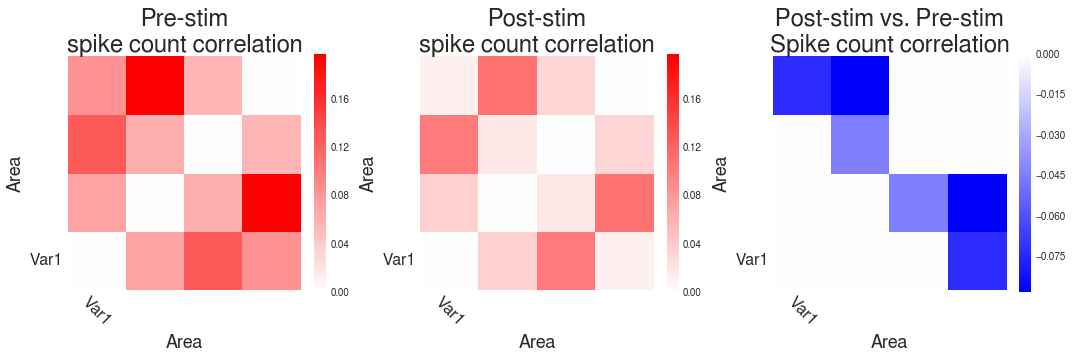

In [216]:
nAreas = 4 #len(areas)

plt.figure(figsize=(15,5))
plt.subplot(131)
cmin = np.min([np.mean(preStimNoiseCorr[:nAreas,:nAreas,:],2),np.mean(postStimNoiseCorr[:nAreas,:nAreas,:],2)])
cmax = np.max([np.mean(preStimNoiseCorr[:nAreas,:nAreas,:],2),np.mean(postStimNoiseCorr[:nAreas,:nAreas,:],2)])
ax = sns.heatmap(np.nanmean(preStimNoiseCorr[:nAreas,:nAreas,:],2),square=True,center=0,
                 vmin=cmin, vmax=cmax,cmap='bwr',xticklabels=20,yticklabels=20,cbar_kws={'fraction':0.046})
plt.xlabel('Area',fontsize=18,fontname='FreeSans')
plt.ylabel('Area',fontsize=18,fontname='FreeSans')
plt.xticks(np.arange(.5,nAreas),areas[:nAreas],rotation=-45,fontsize=16,fontname='FreeSans')
plt.yticks(np.arange(.5,nAreas),areas[:nAreas],fontsize=16,rotation=0,fontname='FreeSans')
plt.title('Pre-stim\nspike count correlation',fontsize=24,fontname='FreeSans')
ax.invert_yaxis()

plt.subplot(132)
ax = sns.heatmap(np.nanmean(postStimNoiseCorr[:nAreas,:nAreas,:],2),square=True,center=0,
                 vmin=cmin, vmax=cmax,cmap='bwr',xticklabels=20,yticklabels=20,cbar_kws={'fraction':0.046})
plt.xlabel('Area',fontsize=18,fontname='FreeSans')
plt.ylabel('Area',fontsize=18,fontname='FreeSans')
plt.xticks(np.arange(.5,nAreas),areas[:nAreas],rotation=-45,fontsize=16,fontname='FreeSans')
plt.yticks(np.arange(.5,nAreas),areas[:nAreas],fontsize=16,rotation=0,fontname='FreeSans')
plt.title('Post-stim\nspike count correlation',fontsize=24,fontname='FreeSans')
ax.invert_yaxis()


plt.subplot(133)
# Post-stim versus Pre-stim t-test
t, p = stats.ttest_rel(postStimNoiseCorr[:nAreas,:nAreas,:],preStimNoiseCorr[:nAreas,:nAreas,:],axis=2)
diff = np.mean(postStimNoiseCorr[:nAreas,:nAreas,:],axis=2)-np.mean(preStimNoiseCorr[:nAreas,:nAreas,:],axis=2)
triu_ind = np.triu_indices(nAreas,k=1)
qs = np.zeros((p.shape))
qs[triu_ind] = mc.fdrcorrection0(p[triu_ind])[0]
qs = qs + qs.T
sigdiff = np.multiply(diff,qs)
# sigdiff = diff
ax = sns.heatmap(sigdiff,square=True,center=0,cmap='bwr',xticklabels=20,yticklabels=20,cbar_kws={'fraction':0.046})
plt.xlabel('Area',fontsize=18,fontname='FreeSans')
plt.ylabel('Area',fontsize=18,fontname='FreeSans')
plt.xticks(np.arange(.5,nAreas),areas[:nAreas],rotation=-45,fontsize=16,fontname='FreeSans')
plt.yticks(np.arange(.5,nAreas),areas[:nAreas],fontsize=16,rotation=0,fontname='FreeSans')
plt.title('Post-stim vs. Pre-stim\nSpike count correlation',fontsize=24,fontname='FreeSans')
ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('Analysis2a_RegionalSpikeCountCorrelations.pdf')

## Compute dimensionality of post-stim correlations vs pre-stim correlations

# Compute average correlation/SD post-stim versus pre-stim, within the same trial, across all neurons

Spiking count correlation
	t = -5.124 | p = 0.0 
Spiking variability
	t = -7.143 | p = 0.0 
Mean firing rate
	t = 3.235 | p = 0.001


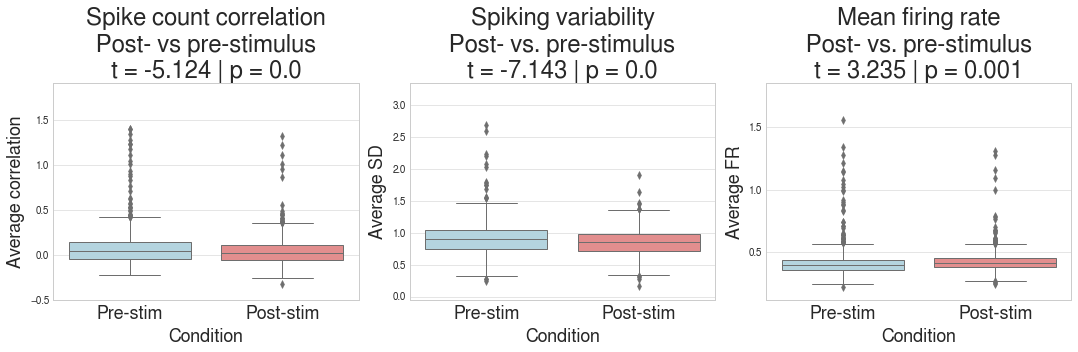

In [175]:
plt.figure(figsize=(15,5))
t, p = stats.ttest_rel(postCorr_avg,preCorr_avg)
# t, p = stats.wilcoxon(postCorr_avg,preCorr_avg)
plt.subplot(131)
tmpdat = [preCorr_avg,postCorr_avg]
sns.boxplot(data=tmpdat,palette=["#add8e6","#f08080"])
plt.xticks(np.arange(2),['Pre-stim','Post-stim'],fontsize=18, fontname='FreeSans');
plt.title('Spike count correlation\nPost- vs pre-stimulus\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)) ,fontsize=24,fontname='FreeSans')
print 'Spiking count correlation\n\tt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),
plt.ylabel('Average correlation',fontsize=18,fontname='FreeSans')
plt.xlabel('Condition',fontsize=18,fontname='FreeSans')
plt.ylim([np.min(tmpdat)-np.std(tmpdat),np.max(tmpdat)+3*np.std(tmpdat)])


t, p = stats.ttest_rel(np.mean(postStimNoiseSD,0),np.mean(preStimNoiseSD,axis=0))
# t, p = stats.wilcoxon(np.mean(postStimNoiseSD**2,0),np.mean(preStimNoiseSD**2,axis=0))
plt.subplot(132)
tmpdat = [np.mean(preStimNoiseSD,axis=0),np.mean(postStimNoiseSD,0)]
sns.boxplot(data=tmpdat,palette=["#add8e6","#f08080"])
plt.xticks(np.arange(2),['Pre-stim','Post-stim'],fontsize=18, fontname='FreeSans');
plt.title('Spiking variability\nPost- vs. pre-stimulus\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),fontsize=24,fontname='FreeSans')
print '\nSpiking variability\n\tt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),
plt.ylabel('Average SD',fontsize=18,fontname='FreeSans')
plt.xlabel('Condition',fontsize=18,fontname='FreeSans')
plt.ylim([np.min(tmpdat)-np.std(tmpdat),np.max(tmpdat)+3*np.std(tmpdat)])


t, p = stats.ttest_rel(np.mean(postStimFR,0),np.mean(preStimFR,axis=0))
print '\nMean firing rate\n\tt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),
# t, p = stats.wilcoxon(np.mean(postStimFR,0),np.mean(preStimFR,axis=0))
plt.subplot(133)
tmpdat = [np.mean(preStimFR,axis=0),np.mean(postStimFR,0)]
sns.boxplot(data=tmpdat,palette=["#add8e6","#f08080"])
plt.xticks(np.arange(2),['Pre-stim','Post-stim'],fontsize=18, fontname='FreeSans');
plt.title('Mean firing rate\nPost- vs. pre-stimulus\nt = ' + str(round(t,3)) + ' | p = ' + str(round(p,3)),fontsize=24,fontname='FreeSans')
plt.ylabel('Average FR',fontsize=18,fontname='FreeSans')
plt.xlabel('Condition',fontsize=18,fontname='FreeSans')
plt.ylim([np.min(tmpdat)-np.std(tmpdat),np.max(tmpdat)+3*np.std(tmpdat)])
plt.tight_layout()
# plt.savefig('Analysis2a_correlationXvariabilityXfr.pdf')


# Calculate CDFs of each region

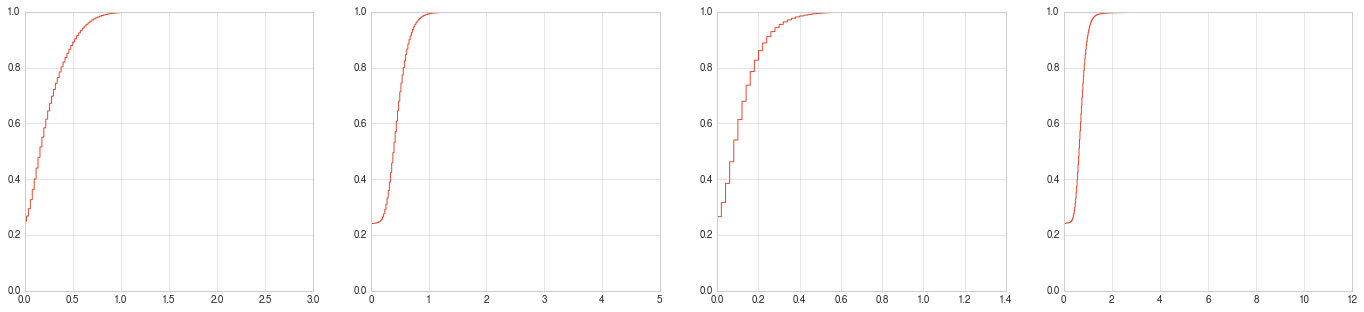

In [176]:
cdf_areas = []
plt.figure(figsize=(30,5))
i=1
for area in range(sta_binned.shape[0]):
    # Identify time point in which recording began
    timeStart = np.min(np.where(sta_binned[0,:,0]!=0)[0])
    timeEnd = np.max(np.where(sta_binned[0,:,0]!=0)[0])
    flatten = sta_binned[i-1,:,:].reshape(-1)
    ecdf = sm.distributions.ECDF(flatten)
#     plt.title(locations[area])
    plt.subplot(1,5,i)
    
    plt.plot(ecdf.x,ecdf.y)
    i += 1
    